In [29]:
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('modules loaded')

modules loaded


<a id="functions"></a>
# <center>Define Needed Support Functions</center>

### Define a function to show example training images

In [67]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    #plt.figure(figsize=(80, 40))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        #plt.subplot(25, 1, i + 1)
        image=images[i]/255
        plt.figure(figsize=(20,20))
        plt.imshow(image, cmap='gray')
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [31]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)
    

### Define  a function to print text in RGB foreground and background colors

In [32]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

<a id="code"></a>
# <center>Define code for custom callback</center>

In [33]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

### Define a function to plot the training data

In [34]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define a function to create confusion matrix and classification report

In [35]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### define a function to save the model and the associated class_dict.csv file

In [36]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    print ('the save path is: ', save_path)
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

### define a function that uses the trained model and the
### class_dict.csv file to predict images

In [37]:
def predictor(sdir, csv_path,  model_path, averaged=True, verbose=True):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    class_count=len(class_df['class'].unique())
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)    
    scale=class_df['scale by'].iloc[0] 
    image_list=[]
    # determine value to scale image pixels by
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
    path_list=[]
    paths=os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    if verbose:
        print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list) 
    image_list=[]
    file_list=[]
    good_image_count=0
    for i in range (image_count):        
        try:
            img=cv2.imread(path_list[i])
            img=cv2.resize(img, img_size)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            good_image_count +=1
            img=img*s2 - s1             
            image_list.append(img)
            file_name=os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print ( path_list[i], ' is an invalid image file')
    if good_image_count==1: # if only a single image need to expand dimensions
        averaged=True
    image_array=np.array(image_list)    
    # make predictions on images, sum the probabilities of each class then find class index with
    # highest probability
    preds=model.predict(image_array)    
    if averaged:
        psum=[]
        for i in range (class_count): # create all 0 values list
            psum.append(0)    
        for p in preds: # iterate over all predictions
            for i in range (class_count):
                psum[i]=psum[i] + p[i]  # sum the probabilities   
        index=np.argmax(psum) # find the class index with the highest probability sum        
        klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
        prob=psum[index]/good_image_count  # get the probability average         
        # to show the correct image run predict again and select first image that has same index
        for img in image_array:  #iterate through the images    
            test_img=np.expand_dims(img, axis=0) # since it is a single image expand dimensions 
            test_index=np.argmax(model.predict(test_img)) # for this image find the class index with highest probability
            if test_index== index: # see if this image has the same index as was selected previously
                if verbose: # show image and print result if verbose=1
                    plt.axis('off')
                    plt.imshow(img) # show the image
                    print (f'predicted species is {klass} with a probability of {prob:6.4f} ')
                break # found an image that represents the predicted class      
        return klass, prob, img, None
    else: # create individual predictions for each image
        pred_class=[]
        prob_list=[]
        for i, p in enumerate(preds):
            index=np.argmax(p) # find the class index with the highest probability sum
            klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
            image_file= file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])            
        Fseries=pd.Series(file_list, name='image file')
        Lseries=pd.Series(pred_class, name= 'species')
        Pseries=pd.Series(prob_list, name='probability')
        df=pd.concat([Fseries, Lseries, Pseries], axis=1)
        if verbose:
            length= len(df)
            print (df.head(length))
        return None, None, None, df

### define a function tha takes in a dataframe df, and integer max_size and a string column
### and returns a dataframe where the number of samples for any class specified by column
### is limited to max samples

In [38]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

### define a function that takes in a dataframe, and integers max_samples, min_samples. 
it uses the function trim to set the maximum number of samples in a class defined by the string column to max_samples.
if the number of samples is less than min_samples the class is eliminated from the dataset. If some classes have
less than max_samples, then augmented images are created for that class  and stored in the working_dir so the class
will have max_samples of images.  After augmentation an aug_df is created for the augmented images in the
working_dir. The aug_df is then merged with the original train_df to produce a new train_df that has exactly
max_sample images in each class thus creating a balanced training set.

In [39]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

<a id="image"></a>
# <center>Input an image and get the shape</center>

(89, 1661)


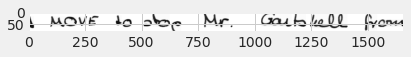

In [62]:
img_path=r'../input/iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-00.png'
img=plt.imread(img_path)
print (img.shape)
imshow(img, cmap='gray')


<a id="data"></a>
# <center>Define preprocess function to read in image file and create dataframes</center>

In [41]:
def preprocess(path_to_txt, path_to_images, trsplit, vsplit):
    #read in the forms_for_parsing,txt file and create a dictionary with key 
    parse_dict={}
    with open(path_to_txt) as f:
        for line in f:
            split=line.split(' ')
            key= split[0]
            author=split[1]
            parse_dict[key]= author
    # generate list of image file paths and their associated list of targets
    flist=sorted(os.listdir(path_to_images))
    filepaths=[]
    labels=[]
    for i, f in enumerate (flist):
        fpath=os.path.join(path_to_images, f)
        filepaths.append(fpath)
        index=f.rfind('.')
        fname=f[:index]        
        fsplit=fname.split('-')
        p= fsplit[0] + '-' + fsplit[1]
        for key in parse_dict:
            if key == p:
                labels.append(str(parse_dict[p]))
        if i > 1000 and i <1005:
            print(filepaths[i], labels[i])
    print('number of filepaths= ', len(filepaths), '  number of labels- ', len(labels))
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    # split df into a train_df, a test_df and a valid_df
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df
            

In [42]:
path_to_txt=r'../input/iam-handwriting-top50/forms_for_parsing.txt'
path_to_images = r'../input/iam-handwriting-top50/data_subset/data_subset'
trsplit=.9
vsplit=.05
train_df, test_df, valid_df=preprocess(path_to_txt, path_to_images, trsplit, vsplit)

../input/iam-handwriting-top50/data_subset/data_subset/b06-056-s01-00.png 125
../input/iam-handwriting-top50/data_subset/data_subset/b06-056-s01-01.png 125
../input/iam-handwriting-top50/data_subset/data_subset/b06-056-s01-02.png 125
../input/iam-handwriting-top50/data_subset/data_subset/b06-056-s01-03.png 125
number of filepaths=  4899   number of labels-  4899
train_df length:  4409   test_df length:  245   valid_df length:  245
[623, 120, 120, 116, 116, 112, 105, 104, 100, 97, 96, 94, 94, 94, 91, 90, 89, 89, 86, 85, 85, 82, 80, 78, 78, 77, 77, 76, 75, 74, 74, 73, 72, 68, 65, 64, 63, 56, 54, 52, 51, 49, 49, 48, 47, 47, 46, 44, 43, 41]


<a id="balance"></a>
# <center>Determne train df class sample balance and adjust if necessary</center>

### The train data set is not balanced and has a limited number of samples in many of the classes. We will use the balance function defined
### above to limit the maximum samples in a class to 120,. Foor classes with less than 120 images the function generates augmented images
### and appends them to train_df

In [43]:
max_samples= 120
min_samples=0
column='labels'
working_dir = r'./'
img_size=(45, 830)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  50
[120, 120, 120, 116, 116, 112, 105, 104, 100, 97, 96, 94, 94, 94, 91, 90, 89, 89, 86, 85, 85, 82, 80, 78, 78, 77, 77, 76, 75, 74, 74, 73, 72, 68, 65, 64, 63, 56, 54, 52, 51, 49, 49, 48, 47, 47, 46, 44, 43, 41]
Found 91 validated image filenames.
Found 46 validated image filenames.
Found 80 validated image filenames.
Found 116 validated image filenames.
Found 47 validated image filenames.
Found 72 validated image filenames.
Found 65 validated image filenames.
Found 75 validated image filenames.
Found 85 validated image filenames.
Found 105 validated image filenames.
Found 63 validated image filenames.
Found 85 validated image filenames.
Found 86 validated image filenames.
Found 116 validated image filenames.
Found 89 validated image filenames.
Found 49 validated image filenames.
Found 96 validated image filenames.
Found 56 validated image filenames.
Found 41 validated image filenames.
Found 112 validated image filenames.
Found 78 validated im

### The train_df dataframe is now balanced with 120 samples per class

<a id="generators"></a>
# <center>Create train, test and validation generators</center>

In [44]:
channels=3
batch_size=20
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
msg='                                                              for the train generator'
print(msg, '\r', end='') 
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='                                                              for the test generator'
print(msg, '\r', end='') 
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
msg='                                                             for the validation generator'
print(msg, '\r', end='')
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  49   test steps:  5
Found 6000 validated image filenames belonging to 50 classes. for the train generator 
Found 245 validated image filenames belonging to 50 classes.  for the test generator 
Found 245 validated image filenames belonging to 50 classes. for the validation generator 


<a id="show"></a>
# <center>Display some training images/center>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


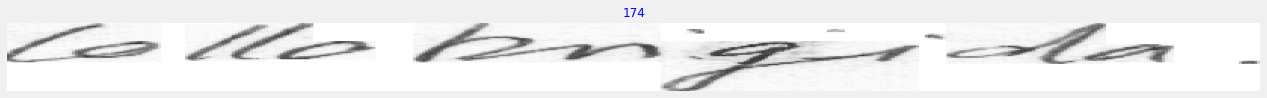

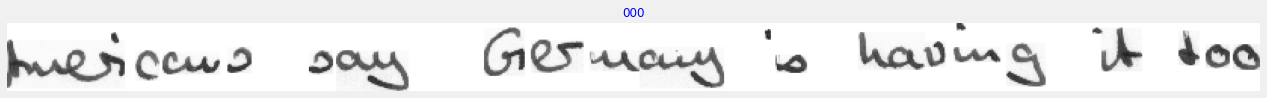

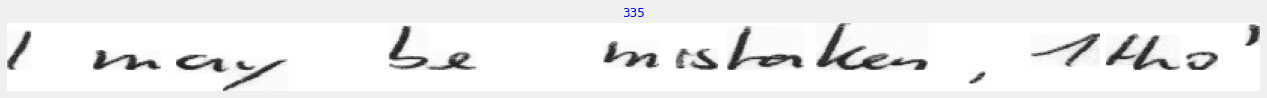

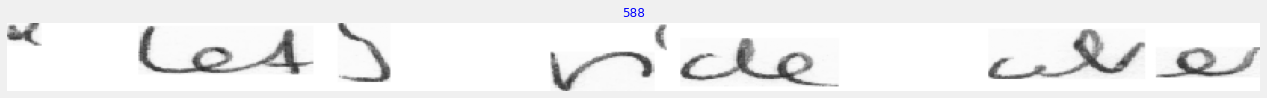

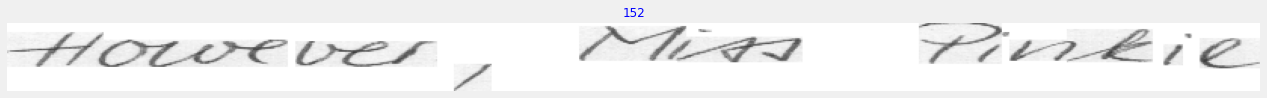

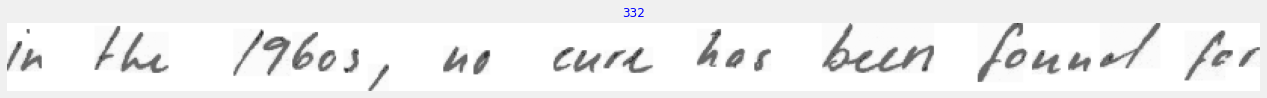

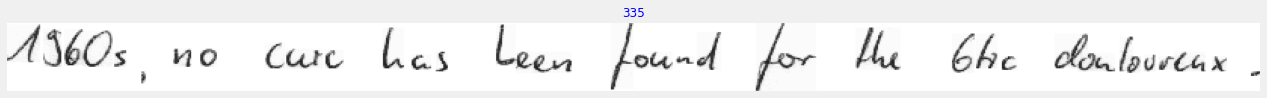

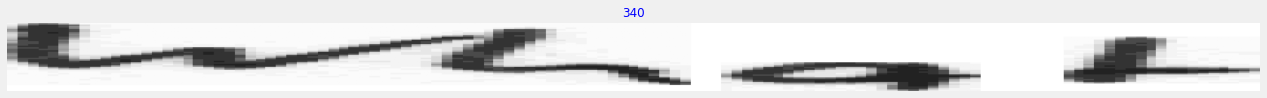

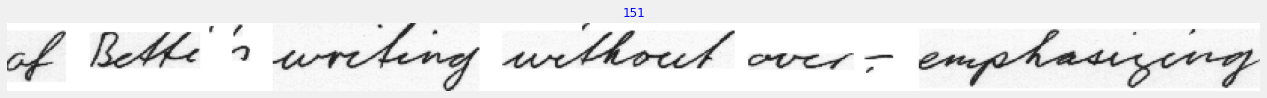

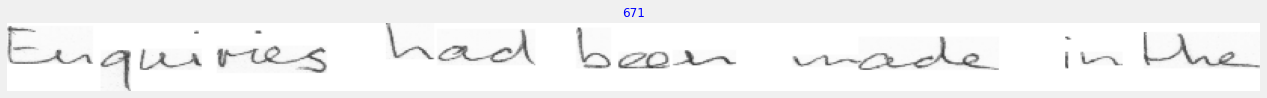

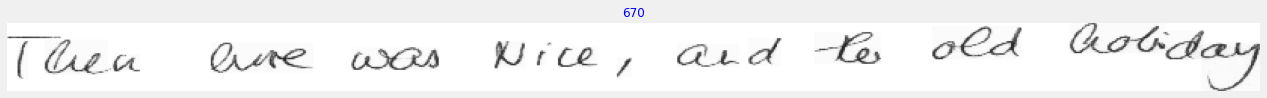

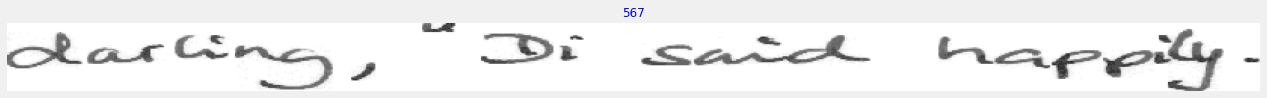

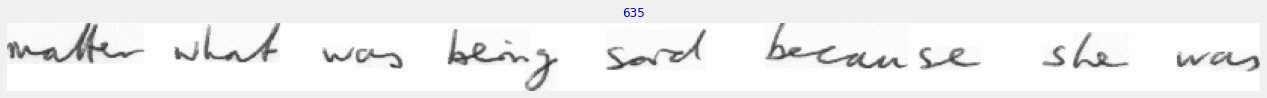

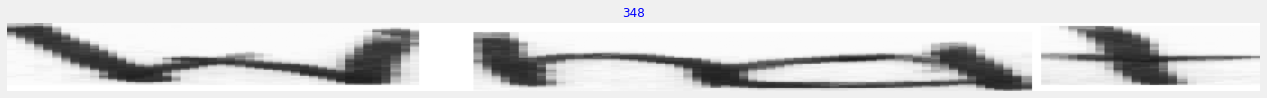

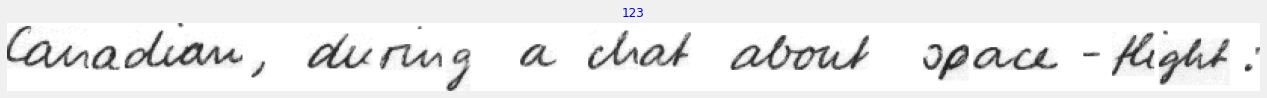

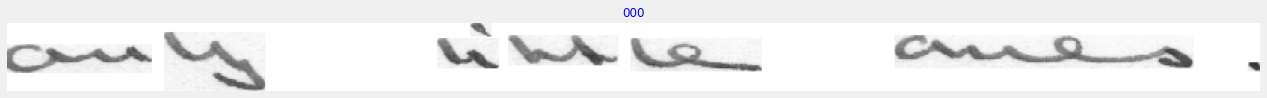

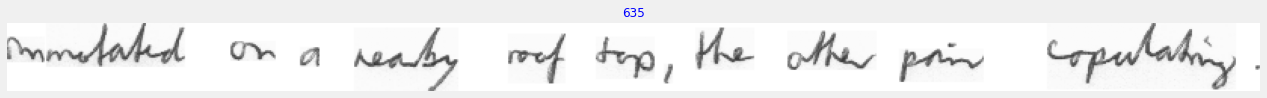

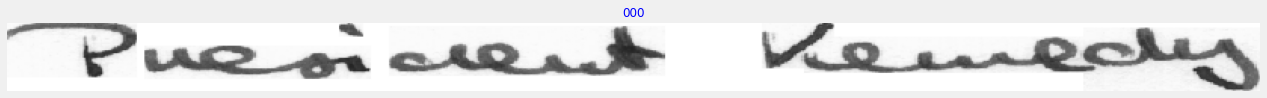

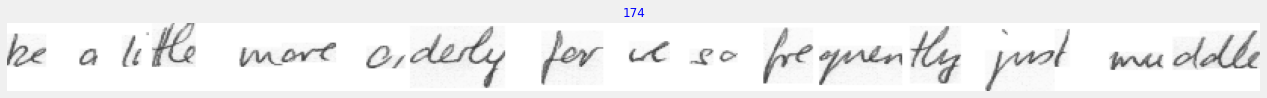

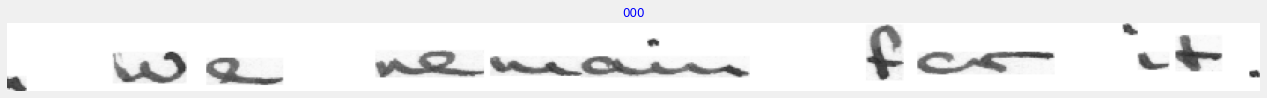

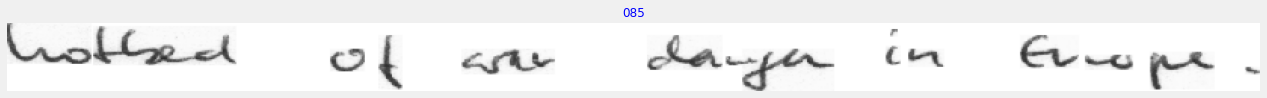

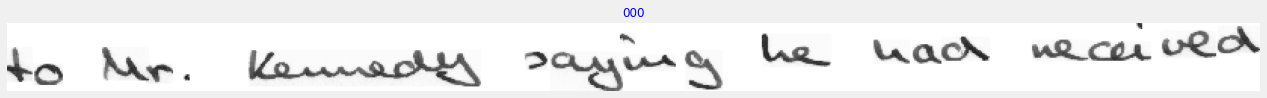

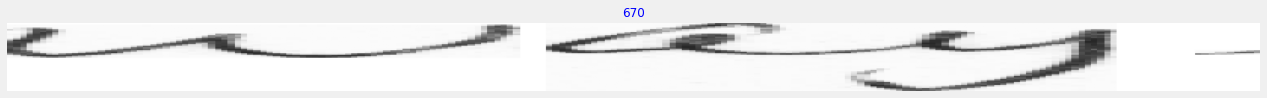

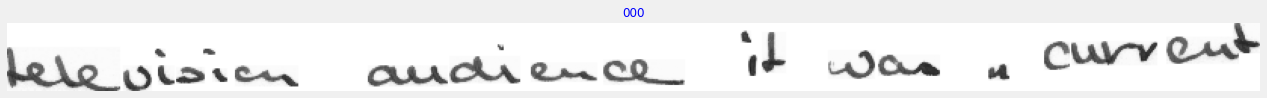

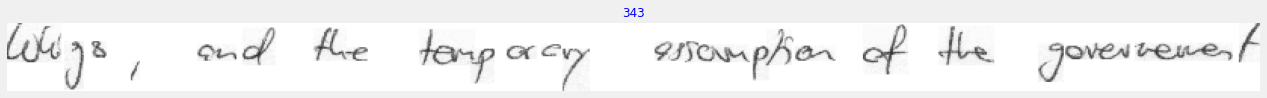

In [68]:
show_image_samples(test_gen)

<a id="model"></a>
# <center>Create and Compile the Model</center>

In [46]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 1s 0us/step


<a id="train"></a>
# <center>Instantiate the Custom Callback and train the model</center>

In [47]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5# number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

In [48]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting training with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     9.657   21.633   7.56854  40.000   0.00100  0.00100  accuracy     0.00    97.29  

 2 /40     6.223   54.617   4.48694  83.673   0.00100  0.00100  accuracy    152.47   75.75  

 3 /40     4.216   72.117   3.01689  89.388   0.00100  0.00100  accuracy    32.04    75.23  

 4 /40     2.923   80.883   2.11837  89.796   0.00100  0.00100  accuracy    12.16    75.80  

 5 /40     2.058   86.750   1.63179  91.429   0.00100  0.00100  accuracy     7.25    75.67  

enter H to halt training or an integer for number of epochs to run then ask again



 5


 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     1.554   89.383   1.27612  91.837   0.00100  0.00100  accuracy     3.04    75.48  

 7 /40     1.239   92.000   0.98584  93.469   0.00100  0.00100  val_loss    22.75    75.48  

 8 /40     1.013   94.050   0.91984  93.878   0.00100  0.00100  val_loss     6.70    75.54  

 9 /40     0.883   95.250   1.10129  86.531   0.00100  0.00050  val_loss    -19.73   75.65  

10 /40     0.841   96.250   0.71294  96.327   0.00050  0.00050  val_loss    22.49    76.08  

enter H to halt training or an integer for number of epochs to run then ask again



 5


 training will continue until epoch 15

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

11 /40     0.744   97.517   0.64112  97.959   0.00050  0.00050  val_loss    10.07    75.75  

12 /40     0.672   98.033   0.60647  97.551   0.00050  0.00050  val_loss     5.40    75.79  

13 /40     0.618   98.567   0.58987  97.959   0.00050  0.00050  val_loss     2.74    76.15  

14 /40     0.579   98.883   0.55747  97.143   0.00050  0.00050  val_loss     5.49    76.29  

15 /40     0.547   99.000   0.53122  97.551   0.00050  0.00050  val_loss     4.71    75.90  

enter H to halt training or an integer for number of epochs to run then ask again



 h


training has been halted at epoch 15 due to user input

Training is completed - model is set with weights from epoch 15 

training elapsed time was 0.0 hours, 20.0 minutes, 3.49 seconds)



<a id="plot"></a>
# <center>Plot training data, evaluate and save the model</center>

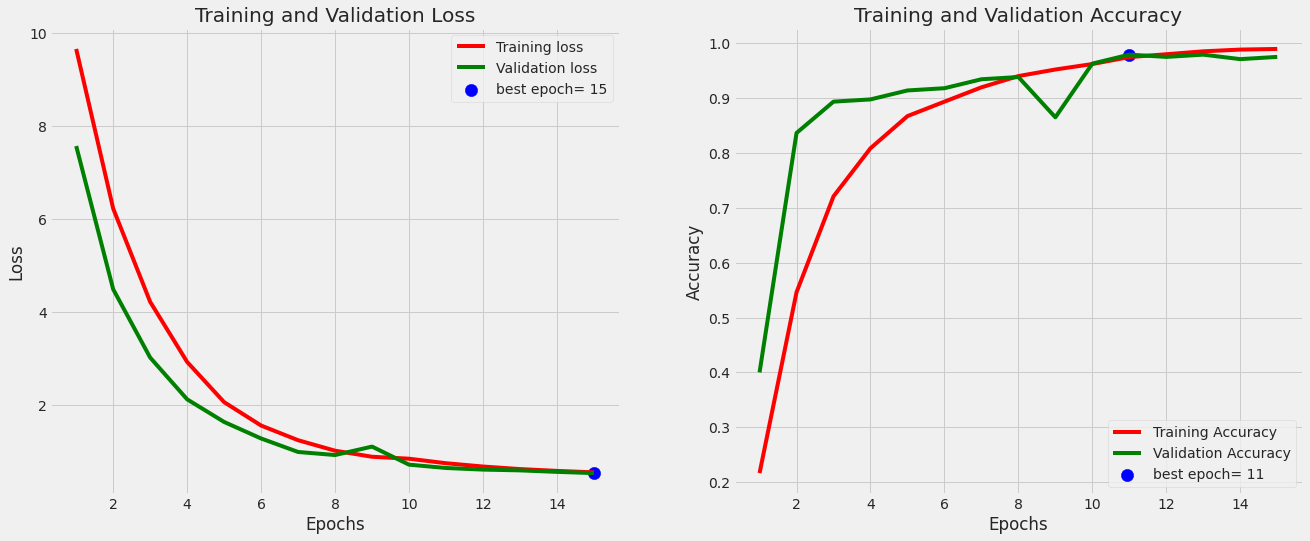

5/5 [==============================] - 2s 271ms/step - loss: 0.5327 - accuracy: 0.9673
accuracy on the test set is 96.73 %

the save path is:  ./


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as ./EfficientNetB3-balls-96.73.h5

class csv file was saved as ./class_dict.csv



In [49]:
tr_plot(history,0)
subject='handwriting'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)